In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
from collections import namedtuple
import torch
import gpytorch
from gpytorch import means, kernels, likelihoods, distributions, lazy
import matplotlib.pyplot as plt
import xarray as xr
import tqdm

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.fair import forward
from src.fair.ancil import get_gas_params, get_thermal_params

<IPython.core.display.Javascript object>

In [3]:
# Load scenarios for training
GtC_to_GtCO2 = 3.67
Gt_to_Mt = 1e3
Tg_to_Gt = 1

def load_input(path):
    inputs = xr.open_dataset(path).compute()
    inputs.CO2.data = inputs.CO2.data / GtC_to_GtCO2
    inputs.CO2.attrs['units'] = 'GtC'
    inputs.CH4.data = inputs.CH4.data * Gt_to_Mt
    inputs.CH4.attrs['units'] = 'MtCH4'
    inputs.SO2.data = inputs.SO2.data * Gt_to_Mt
    inputs.SO2.attrs['units'] = 'MtSO2'
    inputs.BC.data = inputs.BC.data * Gt_to_Mt
    inputs.BC.attrs['units'] = 'MtBC'
    return inputs
    
    
inputs_hist = load_input('../data/inputs_historical.nc')
inputs_ssp126 = load_input('../data/inputs_ssp126.nc')
inputs_ssp370 = load_input('../data/inputs_ssp370.nc')
inputs_ssp585 = load_input('../data/inputs_ssp585.nc')
inputs_train = [inputs_hist, inputs_ssp126, inputs_ssp370, inputs_ssp585]

output_hist = xr.open_dataset('../data/outputs_historical.nc').compute()
output_ssp126 = xr.open_dataset('../data/outputs_ssp126.nc').compute()
output_ssp370 = xr.open_dataset('../data/outputs_ssp370.nc').compute()
output_ssp585 = xr.open_dataset('../data/outputs_ssp585.nc').compute()
outputs_train = [output_hist, output_ssp126, output_ssp370, output_ssp585]

# Load another one for testing
inputs_ssp245 = load_input('../data/inputs_ssp245.nc')
outputs_ssp245 = xr.open_dataset('../data/outputs_ssp245.nc').compute()

In [22]:
outputs_ssp245.tas

<xarray.DataArray 'tas' (member: 3, time: 86, lat: 96, lon: 144)>
array([[[[ 1.6018829 ,  1.6013794 ,  1.6012268 , ...,  1.6017151 ,
           1.6021423 ,  1.6017761 ],
         [ 1.6650848 ,  1.648941  ,  1.6328888 , ...,  1.6801147 ,
           1.6823425 ,  1.6757812 ],
         [ 1.5681152 ,  1.5636902 ,  1.5578613 , ...,  1.570816  ,
           1.5659485 ,  1.567627  ],
         ...,
         [ 2.8788147 ,  2.8441467 ,  2.8144531 , ...,  2.9752502 ,
           2.93927   ,  2.9127197 ],
         [ 3.0028687 ,  2.989624  ,  2.97583   , ...,  3.0403137 ,
           3.0281677 ,  3.012146  ],
         [ 3.0524292 ,  3.0491943 ,  3.0440674 , ...,  3.0519714 ,
           3.0521545 ,  3.0522156 ]],

        [[ 1.2513885 ,  1.2514496 ,  1.2514496 , ...,  1.2511597 ,
           1.2512207 ,  1.2512665 ],
         [ 0.8235016 ,  0.8417511 ,  0.86265564, ...,  0.7683563 ,
           0.7838745 ,  0.8029938 ],
         [ 0.5298157 ,  0.5727234 ,  0.6186981 , ...,  0.4287262 ,
           0.45570374,  0.49247742],
...
         [ 5.0004883 ,  4.9868774 ,  4.9707336 , ...,  5.0219727 ,
           5.013855  ,  5.010559  ],
         [ 5.076782  ,  5.0740967 ,  5.0665894 , ...,  5.0830994 ,
           5.081024  ,  5.0779114 ],
         [ 5.1523438 ,  5.153778  ,  5.155945  , ...,  5.1507263 ,
           5.1511536 ,  5.1516724 ]],

        [[ 2.896164  ,  2.8961182 ,  2.8962402 , ...,  2.8959045 ,
           2.8959503 ,  2.8960876 ],
         [ 3.0007782 ,  3.0108948 ,  3.0177917 , ...,  2.9689636 ,
           2.980072  ,  2.99115   ],
         [ 2.9976654 ,  3.0256348 ,  3.0449982 , ...,  2.8785553 ,
           2.9228973 ,  2.9657288 ],
         ...,
         [ 4.805969  ,  4.7714844 ,  4.7353516 , ...,  4.846283  ,
           4.8377686 ,  4.828705  ],
         [ 5.2017517 ,  5.1813965 ,  5.159546  , ...,  5.2359314 ,
           5.2292786 ,  5.21344   ],
         [ 5.6075745 ,  5.599365  ,  5.585785  , ...,  5.602844  ,
           5.604126  ,  5.6056824 ]]]], dtype=float32)
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time      (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
    quantile  float64 0.9
  * member    (member) int64 1 2 3

In [4]:
# Define named tuples for species emissions
species = ['CO2', 'CH4', 'SO2', 'BC']
Emissions = namedtuple(typename='Emissions', 
                       field_names=species, 
                       defaults=(None,) * len(species))
CummulativeEmissions = namedtuple(typename='CummulativeEmissions', 
                                  field_names=species, 
                                  defaults=(None,) * len(species))


# Extrat emissions and temperature anomaly arrays
def extract_arrays(xr_input, xr_output):
    # Extract time steps array
    time = xr_input.time.values
    
    # Extract cumulative emissions
    cum_CO2_emissions = xr_input.CO2.values
    cum_emissions = CummulativeEmissions(CO2=cum_CO2_emissions)
    
    # Compute emissions
    CO2_emissions = np.append(np.diff(cum_CO2_emissions)[0], np.diff(cum_CO2_emissions))
    CH4_emissions = xr_input.CH4.values
    weights = np.cos(np.deg2rad(xr_input.latitude))
    SO2_emissions = xr_input.SO2.weighted(weights).mean(['latitude', 'longitude']).data
    BC_emissions = xr_input.BC.weighted(weights).mean(['latitude', 'longitude']).data
    emissions = Emissions(CO2=CO2_emissions, CH4=CH4_emissions, 
                          SO2=SO2_emissions, BC=BC_emissions)
    
    # Compute average temperature anomaly
    weights = np.cos(np.deg2rad(xr_output.lat))
    tas = xr_output.tas.weighted(weights).mean(['lat', 'lon', 'member']).data
    return time, cum_emissions, emissions, tas

In [5]:
time_train = []
cum_emissions_train = CummulativeEmissions(CO2=[], CH4=[], SO2=[], BC=[])
emissions_train = Emissions(CO2=[], CH4=[], SO2=[], BC=[])
tas_train = []
for xr_input, xr_output in zip(inputs_train, outputs_train):
    time, cum_emissions, emissions, tas = extract_arrays(xr_input, xr_output)
    time_train.append(time)
    cum_emissions_train.CO2.append(cum_emissions.CO2)
    emissions_train.CO2.append(emissions.CO2)
    emissions_train.CH4.append(emissions.CH4)
    emissions_train.SO2.append(emissions.SO2)
    emissions_train.BC.append(emissions.BC)
    tas_train.append(tas)
time_test, cum_emissions_test, emissions_test, tas_test = extract_arrays(inputs_ssp245, outputs_ssp245)

In [6]:
# Get gas parameters
gas_params_df = get_gas_params(['CO2', 'CH4', 'Sulfur', 'BC'])
gas_kwargs = {k: np.asarray(list(v.values())) 
              for k, v in gas_params_df.T.to_dict().items()}

# Use NORESM2-LM tuned carbon cycle parameters
gas_params_df.loc['r0'].CO2 = 40.7
gas_params_df.loc['rC'].CO2 = 0.00947
gas_params_df.loc['rT'].CO2 = 1.56
gas_params_df.loc['rA'].CO2 = 0.00489

# Use NOREMS2-LM tuned thermal response parameters
d = np.asarray([1.8415484815571417, 230.95025154502827, 0.026163209615848827])
q = np.asarray([0.40863836120319147, 0.21493148593486722, 1.3856950159430294e-12])

# Compute NORESM2-LM carbon concentration -> forcing coefficients
tcr = 1.6759927194452138
F2x = tcr / np.sum(q * (1 - (d / 70) * (1 - np.exp(-70 / d))))
F4x = 7.84599017125608
PI_conc = gas_params_df.loc['PI_conc'].CO2
f3 = (2 * F2x - F4x) / (2 * np.sqrt(PI_conc * 2) - np.sqrt(PI_conc * 4) - np.sqrt(PI_conc))
f1 = (F2x - f3 * (np.sqrt(PI_conc * 2) - np.sqrt(PI_conc))) / np.log(2)
gas_params_df.loc['f1'].CO2 = f1
gas_params_df.loc['f3'].CO2 = f3

# Use NORESM2-LM tuned aerosol concentration -> forcing coefficients
gas_params_df.loc['f2'].Sulfur = -0.00126
gas_params_df.loc['f2'].BC = 0.00302

In [18]:
# Warp up in input dict for FaIR
gas_params_df = get_gas_params()
gas_kwargs = {k: np.asarray(list(v.values())) 
              for k, v in gas_params_df.T.to_dict().items()}
thermal_params_df = get_thermal_params()
d = thermal_params_df.T.d.values
q = thermal_params_df.T.q.values
base_kwargs = {'d': d,
               'q': q,
               **gas_kwargs}

In [40]:
# Run for historical emissions
F_train = []
tas_fair_train = []

time_hist = time_train[0]
emissions_hist = np.stack([emissions_train.CO2[0], 
                           emissions_train.CH4[0],
                           emissions_train.SO2[0],
                           emissions_train.BC[0]])

timestep = np.append(np.diff(time_hist), np.diff(time_hist)[-1])
ext_forcing = np.zeros_like(time_hist)
run_kwargs = {'inp_ar': emissions_hist.reshape(len(species), -1), 
              'timestep': timestep,
              'ext_forcing': ext_forcing,
              **base_kwargs}
res = forward.run(**run_kwargs)
F_train.append(res['RF'])
tas_fair_train.append(res['T'].flatten())

In [41]:
# Run for training ssps
for i in range(1, len(emissions_train.CO2)):
    time = np.concatenate([time_hist, time_train[i]])
    emissions = np.stack([emissions_train.CO2[i], 
                          emissions_train.CH4[i],
                          emissions_train.SO2[i],
                          emissions_train.BC[i]])
    emissions = np.hstack([emissions_hist, emissions])
    timestep = np.append(np.diff(time), np.diff(time)[-1])
    ext_forcing = np.zeros_like(time)
    run_kwargs = {'inp_ar': emissions.reshape(len(species), -1), 
                  'timestep': timestep,
                  'ext_forcing': ext_forcing,
                  **base_kwargs}
    res = forward.run(**run_kwargs)
    F_train.append(res['RF'][:, -len(time_train[i]):])
    tas_fair_train.append(res['T'].flatten()[-len(time_train[i]):])

In [42]:
# Run for testing set
time = np.concatenate([time_hist, time_test])
timestep = np.append(np.diff(time), np.diff(time)[-1])
emissions = np.stack([emissions_test.CO2, 
                      emissions_test.CH4,
                      emissions_test.SO2,
                      emissions_test.BC])
emissions = np.hstack([emissions_hist, emissions])
ext_forcing = np.zeros_like(time)
run_kwargs_test = {'inp_ar': emissions.reshape(len(species), -1),
                   'timestep': timestep,
                   'ext_forcing': ext_forcing,
                   **base_kwargs}
res_test = forward.run(**run_kwargs_test)
F_test = res_test['RF'][:, -len(time_test):]
tas_fair_test = res_test['T'].flatten()[-len(time_test):]

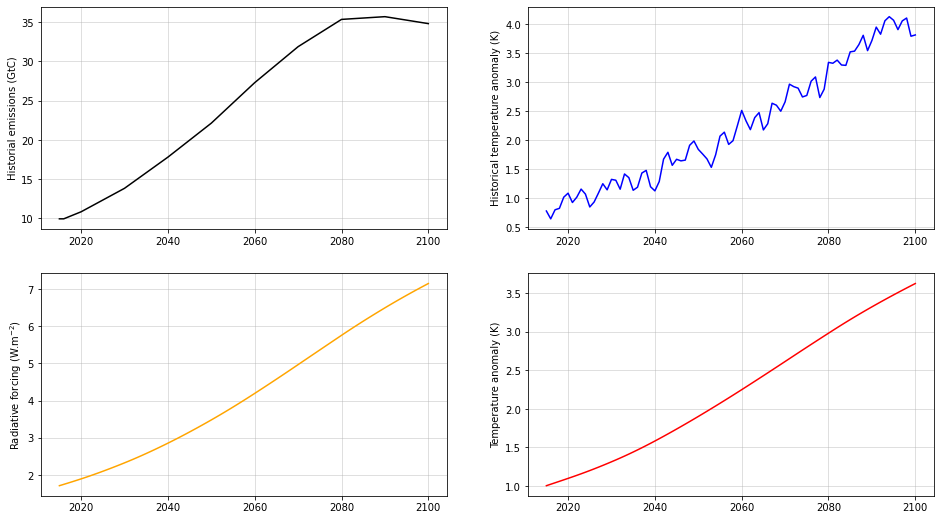

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

idx = 3

ax[0, 0].plot(time_train[idx], emissions_train.CO2[idx].flatten(), color='black')
ax[0, 0].set_ylabel('Historial emissions (GtC)')
ax[0, 0].grid(alpha=0.5)

ax[0, 1].plot(time_train[idx], tas_train[idx], color='blue')
ax[0, 1].set_ylabel('Historical temperature anomaly (K)')
ax[0, 1].grid(alpha=0.5)

ax[1, 0].plot(time_train[idx], F_train[idx][0], color='orange')
ax[1, 0].set_ylabel('Radiative forcing (W.m$^{-2}$)')
ax[1, 0].grid(alpha=0.5)

ax[1, 1].plot(time_train[idx], tas_fair_train[idx], color='red')
ax[1, 1].set_ylabel('Temperature anomaly (K)')
ax[1, 1].grid(alpha=0.5)
plt.show()

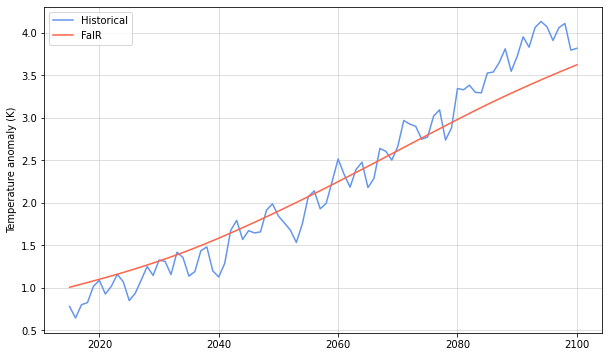

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

idx = 3

ax.plot(time_train[idx], tas_train[idx], color='cornflowerblue', label='Historical')
ax.set_ylabel('Temperature anomaly (K)')
ax.plot(time_train[idx], tas_fair_train[idx].flatten(), color='tomato', label='FaIR')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

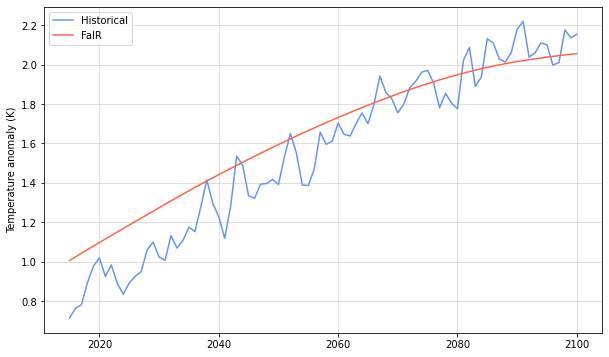

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))


ax.plot(time_test, tas_test, color='cornflowerblue', label='Historical')
ax.set_ylabel('Temperature anomaly (K)')
ax.plot(time_test, tas_fair_test.flatten(), color='tomato', label='FaIR')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (86,) and (251,)

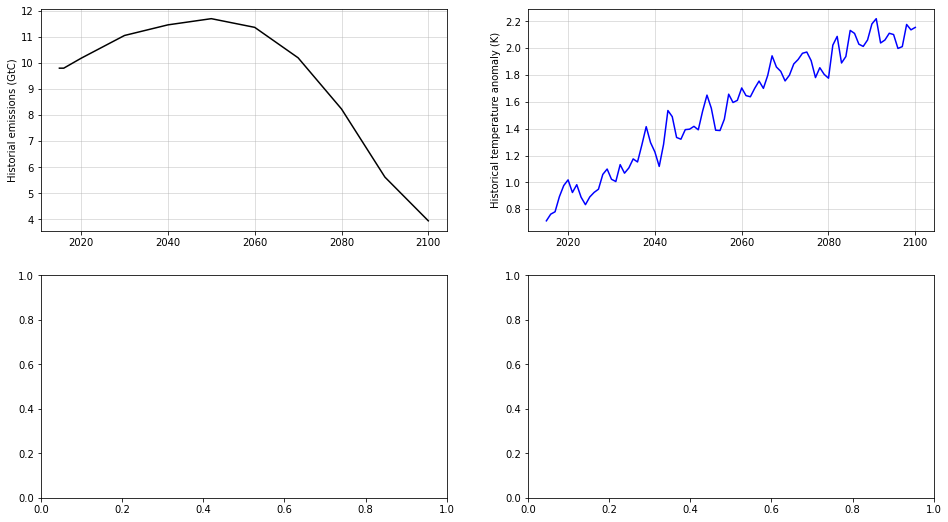

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].plot(time_test, emissions_test.CO2.flatten(), color='black')
ax[0, 0].set_ylabel('Historial emissions (GtC)')
ax[0, 0].grid(alpha=0.5)

ax[0, 1].plot(time_test, tas_test, color='blue')
ax[0, 1].set_ylabel('Historical temperature anomaly (K)')
ax[0, 1].grid(alpha=0.5)

ax[1, 0].plot(time_test, res_test['RF'][0], color='orange')
ax[1, 0].set_ylabel('Radiative forcing (W.m$^{-2}$)')
ax[1, 0].grid(alpha=0.5)

ax[1, 1].plot(time_test, res_test['T'], color='red')
ax[1, 1].set_ylabel('Temperature anomaly (K)')
ax[1, 1].grid(alpha=0.5)
plt.show()

In [93]:
# Run for testing set
timestep = np.append(np.diff(time_test), np.diff(time_test)[-1])
emissions = np.stack([emissions_test.CO2, 
                      emissions_test.CH4,
                      emissions_test.SO2,
                      emissions_test.BC])
ext_forcing = np.zeros_like(time_test)
run_kwargs_test = {'inp_ar': emissions.reshape(len(species), -1), 
                   'timestep': timestep,
                   'ext_forcing': ext_forcing,
                   **base_kwargs}
res_test = forward.run(**run_kwargs_test)

In [267]:
foo_time = np.concatenate([time_train[3], time_test])
timestep = np.append(np.diff(foo_time), np.diff(foo_time)[-1])
emissions = np.stack([np.concatenate([emissions_train.CO2[3], emissions_test.CO2]), 
                      np.concatenate([emissions_train.CH4[3], emissions_test.CH4]),
                      np.concatenate([emissions_train.SO2[3], emissions_test.SO2]),
                      np.concatenate([emissions_train.BC[3], emissions_test.BC])])
ext_forcing = np.zeros_like(foo_time)
run_kwargs_test = {'inp_ar': emissions.reshape(len(species), -1), 
                   'timestep': timestep,
                   'ext_forcing': ext_forcing,
                   **base_kwargs}
run_kwargs_test.update(q=np.array([0.25, 0.15, 0.003]))
res_test = forward.run(**run_kwargs_test)

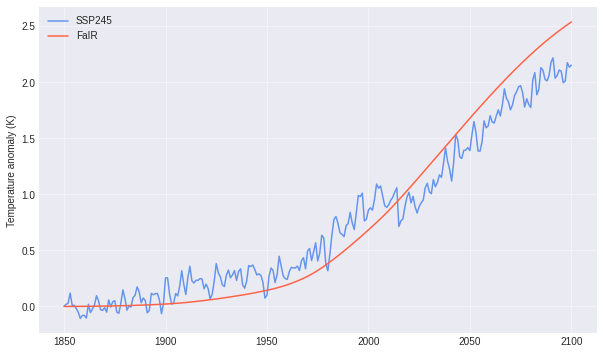

In [268]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(foo_time, np.concatenate([tas_train[3], tas_test]), color='cornflowerblue', label='SSP245')
ax.set_ylabel('Temperature anomaly (K)')
ax.plot(foo_time, res_test['T'].flatten(), color='tomato', label='FaIR')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

In [265]:
foo_time = np.concatenate([time_train[3], time_train[0]])
timestep = np.append(np.diff(foo_time), np.diff(foo_time)[-1])
emissions = np.stack([np.concatenate([emissions_train.CO2[3], emissions_train.CO2[0]]), 
                      np.concatenate([emissions_train.CH4[3], emissions_train.CH4[0]]),
                      np.concatenate([emissions_train.SO2[3], emissions_train.SO2[0]]),
                      np.concatenate([emissions_train.BC[3], emissions_train.BC[0]])])
ext_forcing = np.zeros_like(foo_time)
run_kwargs_test = {'inp_ar': emissions.reshape(len(species), -1), 
                   'timestep': timestep,
                   'ext_forcing': ext_forcing,
                   **base_kwargs}
# run_kwargs_test.update(d=np.array([0.903, 7.92, 355.]),
#                        q=np.array([0.080, 0.1, 0.3]))
run_kwargs_test.update(q=np.array([0.25, 0.15, 0.003]))
res_test = forward.run(**run_kwargs_test)

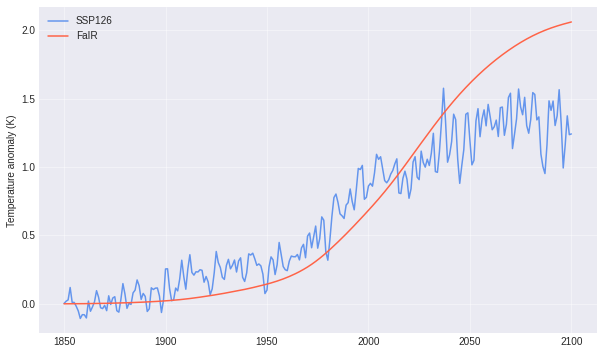

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(foo_time, np.concatenate([tas_train[3], tas_train[0]]), color='cornflowerblue', label='SSP126')
ax.set_ylabel('Temperature anomaly (K)')
ax.plot(foo_time, res_test['T'].flatten(), color='tomato', label='FaIR')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

In [263]:
foo_time = np.concatenate([time_train[3], time_train[1]])
timestep = np.append(np.diff(foo_time), np.diff(foo_time)[-1])
emissions = np.stack([np.concatenate([emissions_train.CO2[3], emissions_train.CO2[1]]), 
                      np.concatenate([emissions_train.CH4[3], emissions_train.CH4[1]]),
                      np.concatenate([emissions_train.SO2[3], emissions_train.SO2[1]]),
                      np.concatenate([emissions_train.BC[3], emissions_train.BC[1]])])
ext_forcing = np.zeros_like(foo_time)
run_kwargs_test = {'inp_ar': emissions.reshape(len(species), -1), 
                   'timestep': timestep,
                   'ext_forcing': ext_forcing,
                   **base_kwargs}
# run_kwargs_test.update(d=np.array([0.903, 7.92, 355.]),
#                        q=np.array([0.080, 0.1, 0.3]))
run_kwargs_test.update(q=np.array([0.25, 0.15, 0.003]))
res_test = forward.run(**run_kwargs_test)

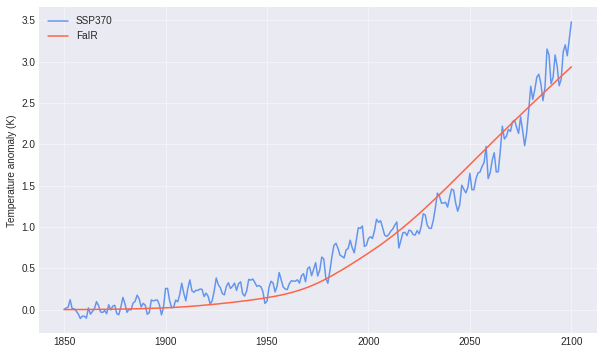

In [264]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(foo_time, np.concatenate([tas_train[3], tas_train[1]]), color='cornflowerblue', label='SSP370')
ax.set_ylabel('Temperature anomaly (K)')
ax.plot(foo_time, res_test['T'].flatten(), color='tomato', label='FaIR')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

In [261]:
foo_time = np.concatenate([time_train[3], time_train[2]])
timestep = np.append(np.diff(foo_time), np.diff(foo_time)[-1])
emissions = np.stack([np.concatenate([emissions_train.CO2[3], emissions_train.CO2[2]]), 
                      np.concatenate([emissions_train.CH4[3], emissions_train.CH4[2]]),
                      np.concatenate([emissions_train.SO2[3], emissions_train.SO2[2]]),
                      np.concatenate([emissions_train.BC[3], emissions_train.BC[2]])])
ext_forcing = np.zeros_like(foo_time)
run_kwargs_test = {'inp_ar': emissions.reshape(len(species), -1), 
                   'timestep': timestep,
                   'ext_forcing': ext_forcing,
                   **base_kwargs}
run_kwargs_test.update(q=np.array([0.25, 0.15, 0.003]))
res_test = forward.run(**run_kwargs_test)

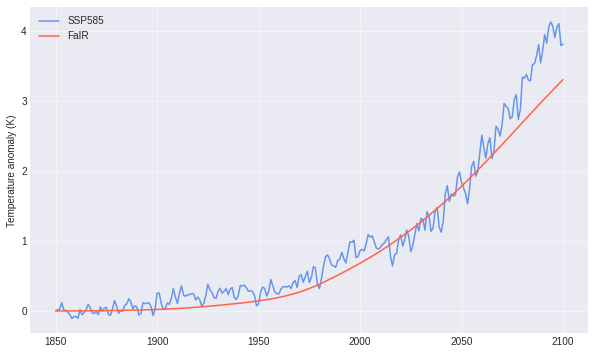

In [262]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(foo_time, np.concatenate([tas_train[3], tas_train[2]]), color='cornflowerblue', label='SSP585')
ax.set_ylabel('Temperature anomaly (K)')
ax.plot(foo_time, res_test['T'].flatten(), color='tomato', label='FaIR')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

In [258]:
import pyam
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (16, 9);

In [195]:
input_df = pd.DataFrame(
        [
            [
                "model_a",
                "scen_a",
                "World",
                "Emissions|CO2",
                "GtC/yr",
                *125*[0],
                *125*[10]
            ],
            [
                "model_a",
                "scen_a",
                "World",
                "Effective Radiative Forcing|Other",
                "W/m**2",
                *[0.5 * np.sin(2 * np.pi * (x) / 14.0) for x in range(250)]
            ],
        ],
        columns=pyam.IAMC_IDX + [*range(2020,2270)],
    )

pyam_inp_df = pyam.IamDataFrame(input_df)
cfg = {}


In [53]:
import torch

In [67]:
torch.multinomial(torch.rand(5), num_samples=5, replacement=True)

tensor([2, 3, 2, 4, 1])